### House Price Data Missing Values Imputation
- Visualize Missing Values and Fill the Missings with appropriate values
- The purpose is to Identify Columns that Require Missing Value Imputation and Replace the Absent Values using Prediction from Random Forest Model

#### Import Required Libraries

In [1]:
library(tidyverse)
library(naniar)
library(ggplot2)
library(repr)
train_path <- '../input/house-prices-advanced-regression-techniques/train.csv'
test_path <- '../input/house-prices-advanced-regression-techniques/test.csv'

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



#### Read Data
- load CSV format data for imputation
    - training set : contains features and label
    - testing set : only contains features

In [2]:
csv_train <- read.csv(train_path, row.names='Id')
csv_test <- read.csv(test_path, row.names='Id')
head(csv_train, 5)
head(csv_test, 5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,⋯,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,⋯,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,Corner,⋯,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,Inside,⋯,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,Inside,⋯,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,Inside,⋯,144,0,NA,NA,NA,0,1,2010,WD,Normal


#### Missing Values Visualization

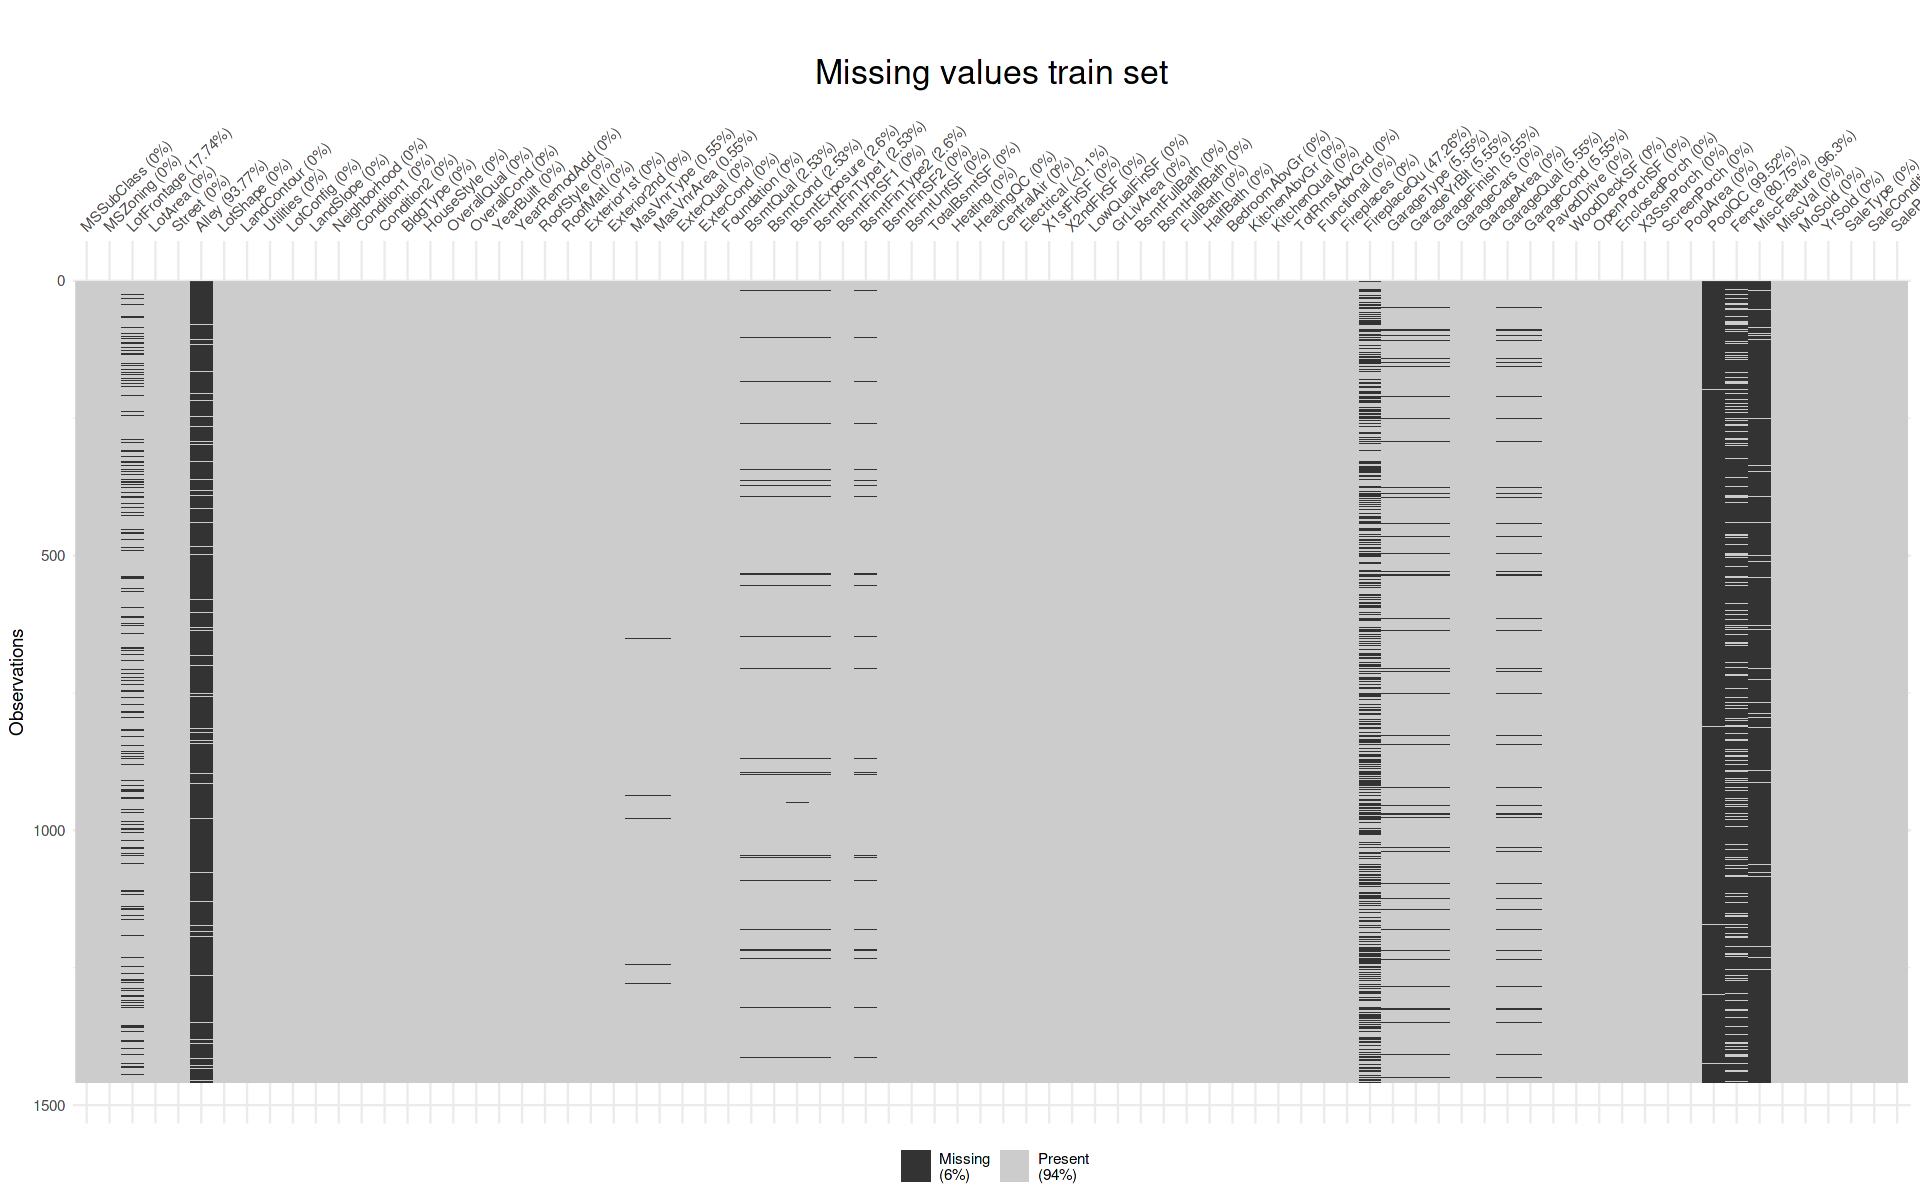

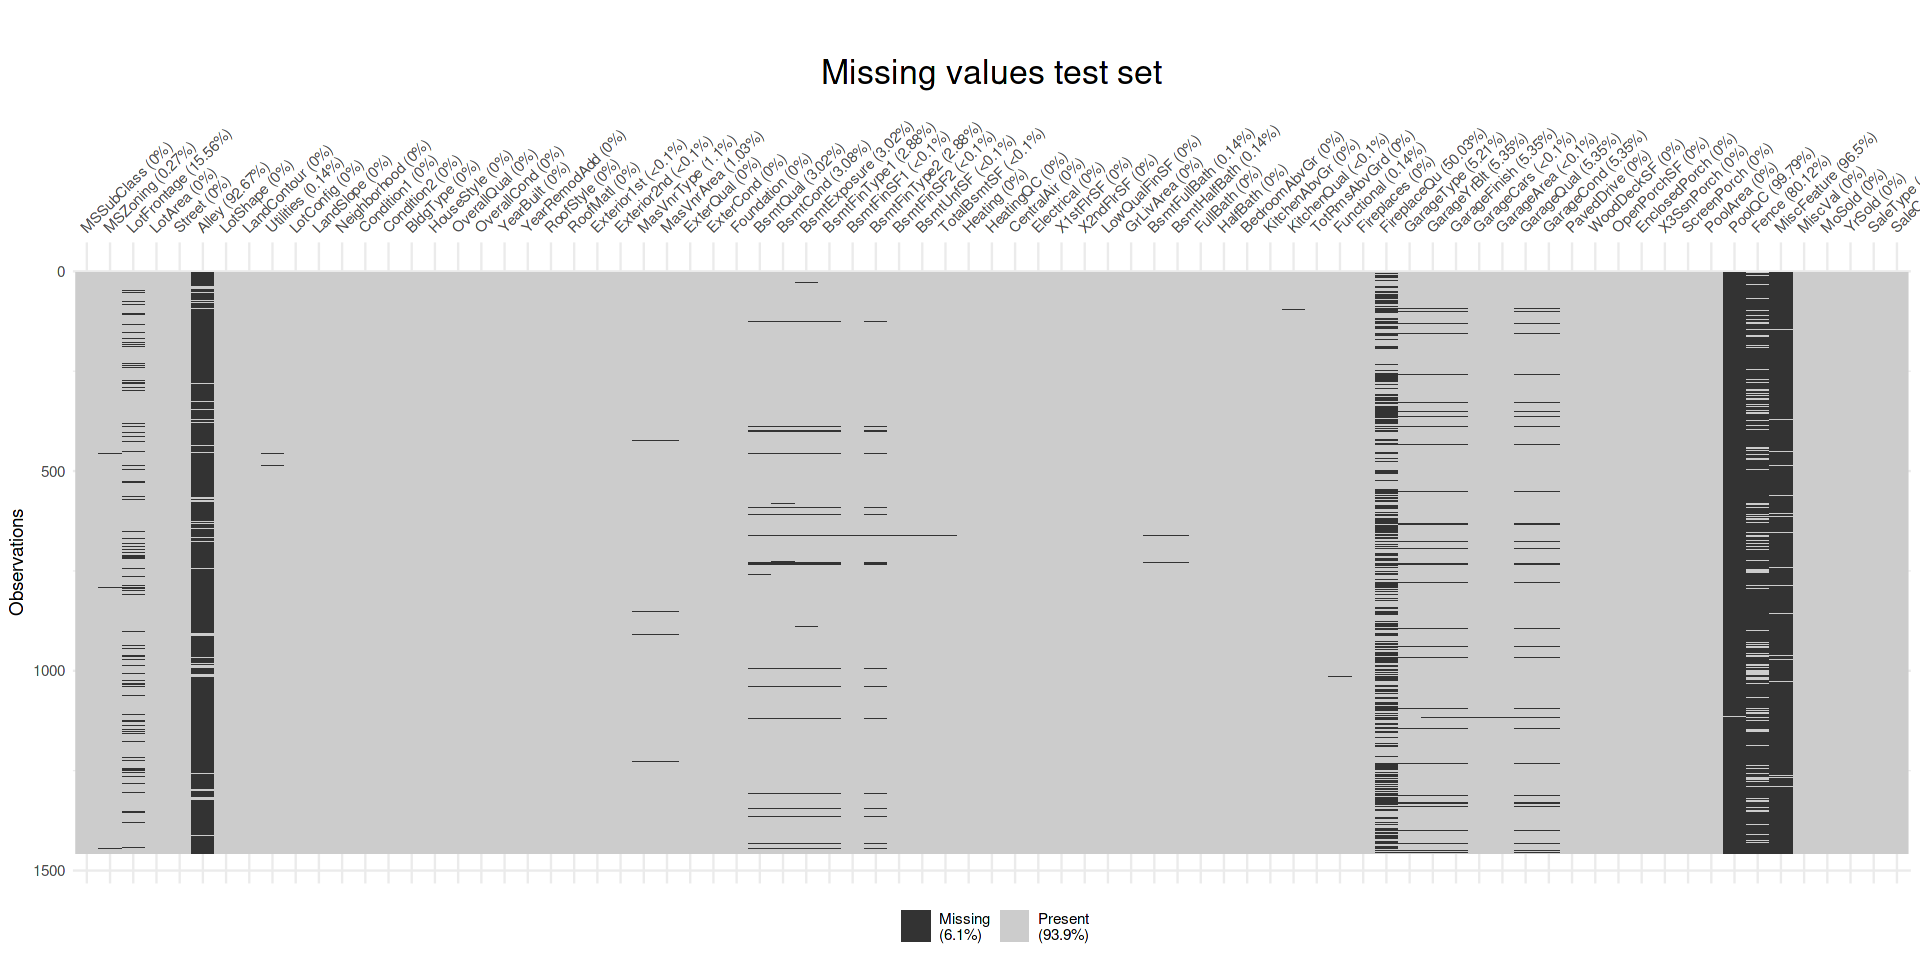

In [5]:
vis_miss(csv_train) + ggtitle('Missing values train set') + theme(plot.title = element_text(hjust = 0.5, size = 20, margin=margin(30,0,0,0)))
options(repr.plot.width=16,repr.plot.height=8)
vis_miss(csv_test) + ggtitle('Missing values test set') + theme(plot.title = element_text(hjust = 0.5, size = 20, margin=margin(30,0,0,0)))
options(repr.plot.width=16,repr.plot.height=8)

- both training and testing set has missing values
- testing set has more columns with missing values than training set

#### Constant Imputation

In [7]:
none_list <- c('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish',
             'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond',
             'BsmtQual', 'MasVnrType')
median_list <- c('LotFrontage')
zero_list <-  c('MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'TotalBsmtSF', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageCars', 'GarageArea', 'BsmtUnfSF')
mode_list <- c('Electrical', 'MSZoning', 'Functional', 'Utilities', 'KitchenQual', 'Exterior1st', 'Exterior2nd')

- separate columns by appropriate fill value according to data description
- fill values used for each column type and reason of using the value are listed as below
    - categorical columns
        - none : absence denotes inexistence
        - column mode : reason of absence cannot be determined
    - numerical columns
        - zero : absence means inexistence
        - column median or mean : reason of absence cannot be determined

In [8]:
csv_train[none_list][is.na(csv_train[none_list])] <- 'None'
csv_train[zero_list][is.na(csv_train[zero_list])] <- 0
csv_test[none_list][is.na(csv_test[none_list])] <- 'None'
csv_test[zero_list][is.na(csv_test[zero_list])] <- 0

#### Feature Transformation

In [9]:
csv_train <- csv_train %>% mutate_if(sapply(csv_train, is.character), as.factor)
csv_test <- csv_test %>% mutate_if(sapply(csv_test, is.character), as.factor)

- originally, categories have character data type but model accepts categorical column that have factor type

#### Random Forest Imputation

In [11]:
library(missForest)
train_X = select(csv_train, -SalePrice)
missF <- missForest(train_X, verbose = TRUE, ntree = 150)

  missForest iteration 1 in progress...done!
    estimated error(s): 0.001382765 0.002088082 
    difference(s): 3.079131e-07 0 
    time: 10.139 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.001377455 0.002231538 
    difference(s): 5.970972e-09 0 
    time: 10.065 seconds

  missForest iteration 3 in progress...done!
    estimated error(s): 0.001378113 0.001976505 
    difference(s): 5.383192e-09 0 
    time: 9.77 seconds

  missForest iteration 4 in progress...done!
    estimated error(s): 0.001374417 0.001992445 
    difference(s): 5.569143e-09 0 
    time: 10.066 seconds



- use information from training set for imputing test set to make both sets receive similar transformation

In [12]:
imp_train_X = missF$ximp
train_test_X <- rbind(csv_test, imp_train_X)
missFTest <- missForest(train_test_X, verbose = TRUE, ntree = 150)

  missForest iteration 1 in progress...done!
    estimated error(s): 0.001391383 0.01572639 
    difference(s): 1.510169e-07 1.59341e-05 
    time: 82.21 seconds

  missForest iteration 2 in progress...done!
    estimated error(s): 0.001398098 0.01623648 
    difference(s): 2.03017e-09 0 
    time: 79.882 seconds

  missForest iteration 3 in progress...done!
    estimated error(s): 0.001388393 0.01578209 
    difference(s): 2.172157e-09 7.967048e-06 
    time: 78.918 seconds



#### Save Imputed Data

In [13]:
copy = imp_train_X
copy$SalePrice = csv_train$SalePrice
head(copy, 5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,<int>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>
1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,Inside,⋯,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,FR2,⋯,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,Inside,⋯,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,Corner,⋯,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,FR2,⋯,0,None,None,None,0,12,2008,WD,Normal,250000


In [15]:
copy_test = missFTest$ximp[1:nrow(csv_test), ]
head(copy_test, 5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,⋯,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
,<int>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>
1461,20,RH,80,11622,Pave,None,Reg,Lvl,AllPub,Inside,⋯,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1462,20,RL,81,14267,Pave,None,IR1,Lvl,AllPub,Corner,⋯,0,0,None,None,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74,13830,Pave,None,IR1,Lvl,AllPub,Inside,⋯,0,0,None,MnPrv,None,0,3,2010,WD,Normal
1464,60,RL,78,9978,Pave,None,IR1,Lvl,AllPub,Inside,⋯,0,0,None,None,None,0,6,2010,WD,Normal
1465,120,RL,43,5005,Pave,None,IR1,HLS,AllPub,Inside,⋯,144,0,None,None,None,0,1,2010,WD,Normal


In [22]:
write.csv(copy, 'train.csv', row.names = TRUE)
write.csv(copy_test, 'test.csv', row.names = TRUE)